In [44]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Preparación de Datos

In [45]:
GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")
data_card_5_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_5_df.csv"), sep=";", encoding="latin1")


In [46]:
# data_card_5_df.set_index('Provincia', inplace=True)
df = data_card_5_df.drop(columns=['Potencia MWh'])


In [47]:
# Renombrar columnas para que coincidan con el formato esperado
df.columns = ['Provincia'] + [f'Consumo {año}' for año in range(2014, 2024)]

    # Preparar los datos para el modelo
    # Vamos a crear un DataFrame largo con todas las observaciones
datos_modelo = []

# Columnas de consumo (excluyendo 'Provincia')
columnas_consumo = [col for col in df.columns if col.startswith('Consumo')]

for provincia in df['Provincia']:
    # Obtener los consumos de cada provincia
    consumos = df[df['Provincia'] == provincia][columnas_consumo].values[0]
    
    # Crear características: provincia, año y consumo
    for i in range(len(consumos) - 1):
        fila = {
            'Provincia': provincia,
            'Año': 2014 + i,
            'Consumo_Actual': consumos[i],
            'Consumo_Siguiente': consumos[i+1]
        }
        datos_modelo.append(fila)

# Convertir a DataFrame
df_modelo = pd.DataFrame(datos_modelo)

# Codificar la provincia (one-hot encoding)
df_modelo_encoded = pd.get_dummies(df_modelo, columns=['Provincia'])

# Preparar características y objetivo
X = df_modelo_encoded.drop('Consumo_Siguiente', axis=1)
y = df_modelo_encoded['Consumo_Siguiente']

# Escalar características numéricas
scaler = StandardScaler()

# Identificar columnas numéricas para escalar
columnas_numericas = ['Año', 'Consumo_Actual']
X[columnas_numericas] = scaler.fit_transform(X[columnas_numericas])
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Función para evaluar los diferentes modelos probados

In [48]:
def evaluar_modelo(modelo):
    modelo.fit(X_train, y_train)

    # Evaluar modelo
    predicciones_test = modelo.predict(X_test)
    mse_scores = -cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='r2')

    # Preparar predicciones para 2028
    predicciones_2028 = {}

    for provincia in df['Provincia']:
        # Crear punto de predicción para 2028
        punto_2028 = X.iloc[-1:].copy()  # Usar la última fila como base
        
        # Actualizar año y consumo actual
        punto_2028['Año'] = 2027
        punto_2028['Consumo_Actual'] = df[df['Provincia'] == provincia][columnas_consumo].values[0][-1]
        
        # Restablecer columnas de provincia
        for col in [c for c in X.columns if c.startswith('Provincia_')]:
            punto_2028[col] = 0
        punto_2028[f'Provincia_{provincia}'] = 1
        
        # Escalar características numéricas
        punto_2028[columnas_numericas] = scaler.transform(punto_2028[columnas_numericas])
        
        # Predecir
        prediccion_2028 = modelo.predict(punto_2028)[0]
        predicciones_2028[provincia] = prediccion_2028

    # Predecir consumo para 2028
    resultados = {
            'predicciones_2028': predicciones_2028,
            'MSE_Mean': mse_scores.mean(),
            'R2_Mean': r2_scores.mean(),
        }

    print("Predicciones de consumo para 2028:")
    for provincia, consumo in resultados['predicciones_2028'].items():
        print(f"{provincia}: {consumo:.2f} MWh")

    print("\nError Cuadrático Medio:", resultados['MSE_Mean'])
    print("R-squared Score:", resultados['R2_Mean'])
    
    return resultados


## 1. Predicción con Random Forest

### Descripción del Modelo
Random Forest es un algoritmo de ensamblaje que construye múltiples árboles de decisión y combina sus predicciones. Sus principales ventajas son:
- Robustez contra el overfitting
- Manejo de relaciones no lineales
- Capacidad de capturar interacciones complejas entre características

In [49]:
resultados_rf = evaluar_modelo(RandomForestRegressor())

Predicciones de consumo para 2028:
Albacete: 469019.34 MWh
Ciudad Real: 656832.64 MWh
Cuenca: 210298.60 MWh
Guadalajara: 328995.92 MWh
Toledo: 1061263.40 MWh

Error Cuadrático Medio: 714145345.7981322
R-squared Score: 0.9894941062035013


## 2. Predicción con Gradient Boosting

### Descripción del Modelo
Gradient Boosting construye un modelo predictivo de forma secuencial, donde cada nuevo modelo corrige los errores del modelo anterior:
- Muy preciso en múltiples tipos de datos
- Maneja bien relaciones no lineales
- Menor riesgo de overfitting comparado con modelos individuales


In [50]:
resultados_gb = evaluar_modelo(GradientBoostingRegressor())

Predicciones de consumo para 2028:
Albacete: 459708.08 MWh
Ciudad Real: 662762.29 MWh
Cuenca: 209549.28 MWh
Guadalajara: 311718.03 MWh
Toledo: 1056333.25 MWh

Error Cuadrático Medio: 1079226096.8340526
R-squared Score: 0.982648521988134


## 3. Predicción con Regresión Polinómica

### Descripción del Modelo
La Regresión Polinómica permite capturar relaciones no lineales mediante transformación de características:
- Útil cuando la relación entre variables no es lineal
- Grados polinómicos diferentes capturan distintos tipos de no linealidad
- Riesgo de overfitting con grados muy altos


In [51]:
resultados_rp = evaluar_modelo(Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lr', LinearRegression())
]))

Predicciones de consumo para 2028:
Albacete: 309861.61 MWh
Ciudad Real: 400911.25 MWh
Cuenca: -1282.30 MWh
Guadalajara: 187986.60 MWh
Toledo: 823529.71 MWh

Error Cuadrático Medio: 8281151741.839678
R-squared Score: 0.9112740159351794


## 4. Predicción con Árbol de Decisión

### Descripción del Modelo
Los Árboles de Decisión dividen recursivamente los datos basándose en criterios de división:
- Muy interpretables
- Capturan relaciones no lineales
- Tienden a sobreajustarse si no se controla la profundidad


In [52]:
resultados_dt = evaluar_modelo(DecisionTreeRegressor())

Predicciones de consumo para 2028:
Albacete: 459494.65 MWh
Ciudad Real: 663051.46 MWh
Cuenca: 202449.61 MWh
Guadalajara: 312108.64 MWh
Toledo: 1057303.97 MWh

Error Cuadrático Medio: 1159063660.9219239
R-squared Score: 0.9830507072590832


## Elección del mejor modelo para nuestra hipótesis

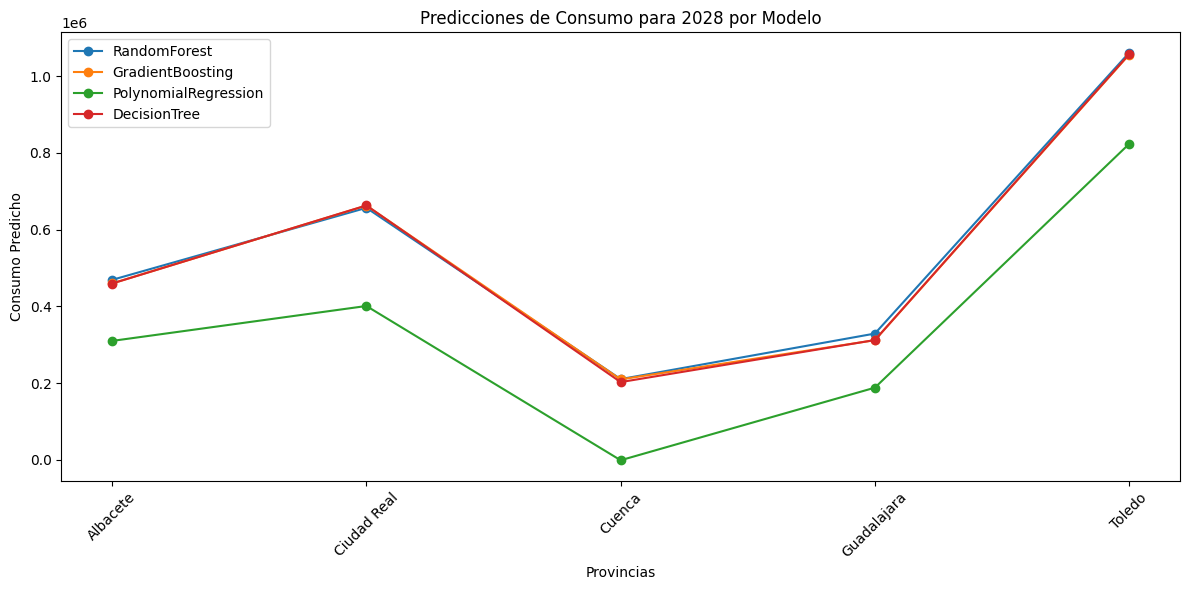

In [53]:
predicciones_2028 = {}
predicciones_2028['RandomForest'] = resultados_rf['predicciones_2028']
predicciones_2028['GradientBoosting'] = resultados_gb['predicciones_2028']
predicciones_2028['PolynomialRegression'] = resultados_rp['predicciones_2028']
predicciones_2028['DecisionTree'] = resultados_dt['predicciones_2028']

# Gráfico de predicciones para 2028
plt.figure(figsize=(12, 6))
for nombre, predicciones in predicciones_2028.items():
    plt.plot(list(predicciones.keys()), list(predicciones.values()), label=nombre, marker='o')

plt.title('Predicciones de Consumo para 2028 por Modelo')
plt.xlabel('Provincias')
plt.ylabel('Consumo Predicho')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Como podemos observar en la gráfica al igual que comparando los valores R2 y MSE podríamos decantarnos por la regresion de Random Forest, Gradient Boosting o Decision Tree, aunque de entre ellos tiene un R2 más cercano a 1 y el MSE más bajo el Random Forest por tanto tomaremos este modelo

## Predicción del consumo en el año 2028

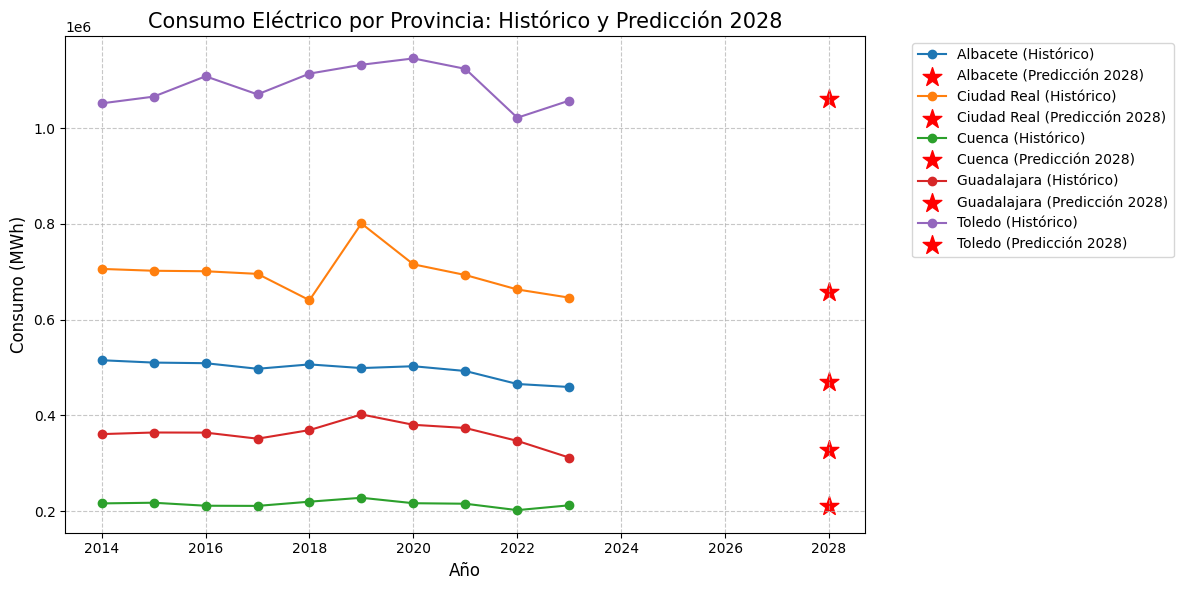

In [54]:
datos = df
predicciones_2028 = resultados_rf['predicciones_2028']
plt.figure(figsize=(12, 6))

# Columnas de consumo
columnas_consumo = [col for col in datos.columns if col.startswith('Consumo')]

# Configurar estilo
plt.style.use('default')

# Graficar series históricas y predicciones
for provincia in datos['Provincia']:
    # Datos históricos
    consumos_historicos = datos[datos['Provincia'] == provincia][columnas_consumo].values[0]
    años_historicos = list(range(2014, 2024))
    
    # Graficar línea histórica
    plt.plot(años_historicos, consumos_historicos, marker='o', label=f'{provincia} (Histórico)')
    
    # Añadir punto de predicción para 2028
    plt.scatter(2028, predicciones_2028[provincia], marker='*', 
                color='red', s=200, 
                label=f'{provincia} (Predicción 2028)')

plt.title('Consumo Eléctrico por Provincia: Histórico y Predicción 2028', fontsize=15)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [55]:
placas = data_card_5_df['Potencia MWh']
placas_2028 = []
for i in range(len(placas)):
    placas_2028.append(placas[i]*predicciones_2028[data_card_5_df['Provincia'][i]])

print("Predicciones de placas para 2028:")
for i in range(len(placas)):
    print(f"{data_card_5_df['Provincia'][i]}: {placas_2028[i]:.2f} placas")
    
print("Total de placas necesarias en 2028 en Castilla La Mancha:", sum(placas_2028))
    

Predicciones de placas para 2028:
Albacete: 768416.66 placas
Ciudad Real: 1066834.93 placas
Cuenca: 338169.33 placas
Guadalajara: 512387.60 placas
Toledo: 1727130.27 placas
Total de placas necesarias en 2028 en Castilla La Mancha: 4412938.787110988
